In [1]:
import pandas as pd
import yfinance as yf

#---
from itertools import combinations, product
from functools import partial
import numpy as np
from numpy.linalg import norm as np_norm
from sklearn.linear_model import LinearRegression as lr
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import minimize as sp_minimize


In [2]:

# NOTE: Move this to an external file so that it can be imported and ran whenever;
# TODO: Add options data pulling with either yahoo_finXYZ or financetoolkit

# def close_prices(tickers):
# 	history = {tic: yf.Ticker(tic).history(period = "max") for tic in tickers}
# 	indexes = [set(data.index) for data in history.values()]
# 	index = sorted(set.union(*indexes))
# 	closes = pd.concat([history[tic].reindex(index = index)['Close'].ffill() for tic in tickers], axis=1)
# 	closes.columns = tickers
# 	stacked = closes.stack().reset_index()
# 	stacked.columns = ['date', 'ticker', 'price']
# 	return stacked

# yf_tickers = ['nio', 'djt', 'gme', 'aapl', 'tsla', 'msft', 'dis', 'ge', 'rivn', 'lcid', 'goog', 'amzn', 'bros', 'amd', 'nvda']
# prices = (close_prices(yf_tickers).pivot(index='date', columns='ticker', values='price'))
# prices.head()
# prices.to_parquet('prices_yf.parquet')

## <center>Normalize Prices & 'Returns'</center>

In [2]:
prices = pd.read_parquet("prices_yf.parquet")
THRES = 0.8
N_DAYS = 500
_nulls = prices.isnull().mean(axis=0)
stocks_w_nans = _nulls[_nulls > THRES].sort_values()
stocks_w_nans

ticker
nio     0.905010
lcid    0.937223
bros    0.953012
djt     0.953710
rivn    0.955549
dtype: float64

In [3]:
cols = prices.columns
stocks = cols[~cols.isin(stocks_w_nans.index)]

prices = prices.loc[:, stocks].ffill().dropna().iloc[:N_DAYS, :]

returns = prices.pct_change().iloc[1:, :]  # not clean!
returns

ticker,aapl,amd,amzn,dis,ge,gme,goog,msft,nvda,tsla
date,,,,,,,,,,
2010-06-30 00:00:00-04:00,-0.018113,-0.021390,0.005985,-0.024768,-0.004144,0.025655,-0.020495,-0.012870,-0.025763,-0.002511
2010-07-01 00:00:00-04:00,-0.012126,0.009563,0.015559,-0.000317,-0.020805,0.014901,-0.012271,0.006519,0.016650,-0.078473
2010-07-02 00:00:00-04:00,-0.006198,-0.029770,-0.016402,-0.003493,-0.016997,-0.041950,-0.006690,0.004750,-0.012524,-0.125683
2010-07-06 00:00:00-04:00,0.006844,-0.018131,0.008430,0.010835,0.006484,0.007115,-0.001100,0.023636,-0.010732,-0.160937
2010-07-07 00:00:00-04:00,0.040381,0.049716,0.030620,0.044767,0.046529,0.019022,0.032403,0.020151,0.048323,-0.019243
...,...,...,...,...,...,...,...,...,...,...
2012-06-14 00:00:00-04:00,-0.001101,0.000000,-0.001304,0.020550,0.018069,-0.020431,-0.003636,0.007209,-0.012315,-0.012765
2012-06-15 00:00:00-04:00,0.004549,0.019097,0.018186,-0.001908,0.017035,0.005073,0.009767,0.023176,0.021613,0.017693
2012-06-18 00:00:00-04:00,0.020292,0.010221,0.019739,0.000213,-0.012500,0.021874,0.011231,-0.005996,0.008950,0.064527


## <center>Some Plots</center>

<Axes: xlabel='amd', ylabel='ge'>

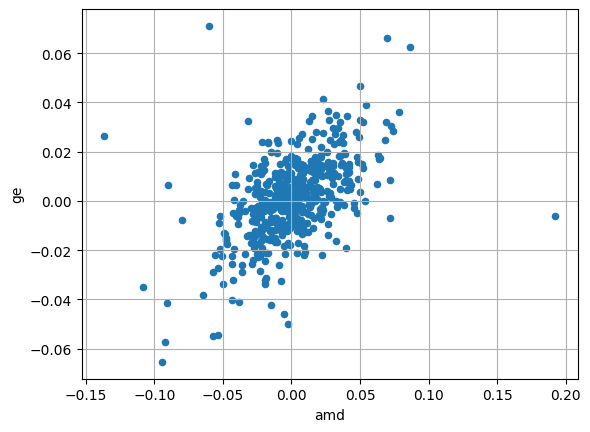

In [5]:
cpl = ('amd', 'ge')
dic_cpl = {'x': cpl[0], 'y': cpl[1]}
returns_cpl = returns.loc[:, cpl]
returns.plot.scatter(**dic_cpl, grid = True)

<Axes: xlabel='amd', ylabel='ge'>

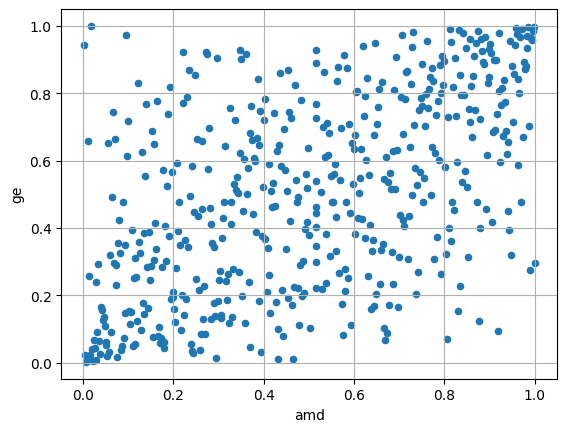

In [6]:
ranks = returns_cpl.rank()
ranks = ranks / ranks.max()
ranks.plot.scatter(**dic_cpl, grid = True)

In [7]:
ranks_vals = ranks.values
_x = ranks_vals[:, 0]
_y = ranks_vals[:, 1]

C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466450.py:2: RuntimeWarning: overflow encountered in power
  return (1 / theta * np.log(_x**-theta + _y**-theta - 1)).sum()


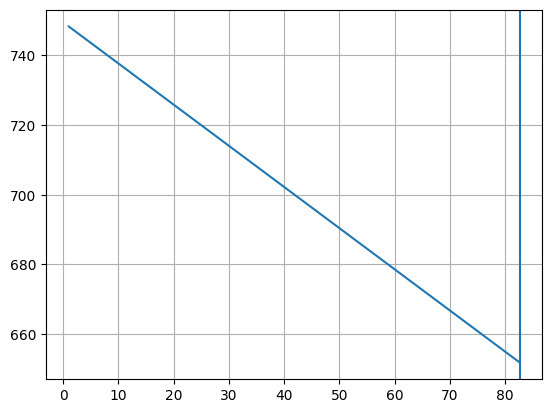

In [11]:
def log_clayton(theta):
    return (1 / theta * np.log(_x**-theta + _y**-theta - 1)).sum()


def jac(theta):
    return (
        -1 / theta**2 * np.log(_x**-theta + _y**-theta - 1)
        - (_x ** -(theta + 1) + _y ** -(theta + 1)) / (_x**-theta + _y**-theta - 1)
    ).sum()

thetas = np.linspace(1, 4e3)
vals = [log_clayton(theta) for theta in thetas]
argmin = thetas[np.argmin(vals)]
plt.plot(thetas, vals)
plt.axvline(argmin)
plt.grid(True)
plt.show()

In [12]:
sp_minimize(log_clayton, 1, method='L-BFGS-B')

C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466450.py:2: RuntimeWarning: overflow encountered in power
  return (1 / theta * np.log(_x**-theta + _y**-theta - 1)).sum()
c:\Users\eorlo\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 651.8490202674857
        x: [ 1.060e+02]
      nit: 19
      jac: [-1.307e-03]
     nfev: 42
     njev: 21
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [13]:
sp_minimize(log_clayton, 1, method='L-BFGS-B', jac=jac)

C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466450.py:2: RuntimeWarning: overflow encountered in power
  return (1 / theta * np.log(_x**-theta + _y**-theta - 1)).sum()
C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466450.py:7: RuntimeWarning: overflow encountered in power
  -1 / theta**2 * np.log(_x**-theta + _y**-theta - 1)
C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466450.py:8: RuntimeWarning: overflow encountered in power
  - (_x ** -(theta + 1) + _y ** -(theta + 1)) / (_x**-theta + _y**-theta - 1)
C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466450.py:8: RuntimeWarning: invalid value encountered in divide
  - (_x ** -(theta + 1) + _y ** -(theta + 1)) / (_x**-theta + _y**-theta - 1)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 653.6217772956422
        x: [ 1.772e+01]
      nit: 2
      jac: [-5.079e+03]
     nfev: 11
     njev: 11
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [14]:
def wrapper_minimize(method, with_jac):
	kwarg = {'jac': jac} if with_jac else {}
	res = dict(sp_minimize(log_clayton, 1, method = method, **kwarg))
	res = {k: v for k, v in res.items() if k in ['nit', 'nfev', 'status', 'success', 'message', 'x']}
	return pd.Series(res).rename(method + ('_with_jac' if with_jac else '_without_jac'))

In [15]:
methods_w_jac = []
methods_wo_jac = [
    'Nelder-Mead',
    'Powell',
    'CG',
    'BFGS',
    'L-BFGS-B',
    'TNC',
    'COBYLA',
    'SLSQP',
    'trust-constr',
]
params = pd.DataFrame(data=list(product(methods_wo_jac, [True, False])) + list(product(methods_w_jac, [True])))
params.columns = ['method', 'with_jac']
params.dtypes

method      object
with_jac      bool
dtype: object

In [17]:
res = {param: wrapper_minimize(param.method, param.with_jac) for param in params.itertuples()}
res = pd.concat(res.values(), axis=1)

C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\1990473999.py:3: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  res = dict(sp_minimize(log_clayton, 1, method = method, **kwarg))
C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466450.py:2: RuntimeWarning: overflow encountered in power
  return (1 / theta * np.log(_x**-theta + _y**-theta - 1)).sum()
C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\1990473999.py:3: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = dict(sp_minimize(log_clayton, 1, method = method, **kwarg))
C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466450.py:7: RuntimeWarning: overflow encountered in power
  -1 / theta**2 * np.log(_x**-theta + _y**-theta - 1)
C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466450.py:8: RuntimeWarning: overflow encountered in power
  - (_x ** -(theta + 1) + _y ** -(theta + 1)) / (_x**-theta + _y**-theta - 1)
C:\Users\eorlo\AppData\Local\Temp\ipykernel_7216\426466

In [18]:
res

,Nelder-Mead_with_jac,Nelder-Mead_without_jac,Powell_with_jac,Powell_without_jac,CG_with_jac,CG_without_jac,BFGS_with_jac,BFGS_without_jac,L-BFGS-B_with_jac,L-BFGS-B_without_jac,TNC_with_jac,TNC_without_jac,COBYLA_with_jac,COBYLA_without_jac,SLSQP_with_jac,SLSQP_without_jac,trust-constr_with_jac,trust-constr_without_jac
nit,41,41,2,2,0,24,0,19,2,19,2,2,NaN,NaN,100,31,1000,1000
nfev,82,82,42,42,25,618,25,61,11,42,54,146,138,138,1090,108,114,42
status,0,0,0,0,2,3,2,2,0,0,1,4,1,1,9,0,0,0
success,True,True,True,True,False,False,False,False,True,True,True,False,True,True,False,True,False,False
message,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,Desired error not necessarily achieved due to ...,NaN result encountered.,Desired error not necessarily achieved due to ...,Desired error not necessarily achieved due to ...,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,Converged (|f_n-f_(n-1)| ~= 0),Linear search failed,Optimization terminated successfully.,Optimization terminated successfully.,Iteration limit reached,Optimization terminated successfully,The maximum number of function evaluations is ...,The maximum number of function evaluations is ...
x,[114.24863281250013],[114.24863281250013],[114.24865816900369],[114.24865816900369],[1.0],[114.58481572862236],[1.0],[112.68050941965342],[17.71503604927368],[106.02371796692063],[21.00000000000007],[22.999999999999975],[114.248779296875],[114.248779296875],[4.771435289824223],[114.24435183606795],[114.0],[106.02565699758708]


In [19]:
res.loc[:, res.loc['success', :]]

,Nelder-Mead_with_jac,Nelder-Mead_without_jac,Powell_with_jac,Powell_without_jac,L-BFGS-B_with_jac,L-BFGS-B_without_jac,TNC_with_jac,COBYLA_with_jac,COBYLA_without_jac,SLSQP_without_jac
nit,41,41,2,2,2,19,2,NaN,NaN,31
nfev,82,82,42,42,11,42,54,138,138,108
status,0,0,0,0,0,0,1,1,1,0
success,True,True,True,True,True,True,True,True,True,True
message,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,Converged (|f_n-f_(n-1)| ~= 0),Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully
x,[114.24863281250013],[114.24863281250013],[114.24865816900369],[114.24865816900369],[17.71503604927368],[106.02371796692063],[21.00000000000007],[114.248779296875],[114.248779296875],[114.24435183606795]


In [21]:
def cdf(rands):
	return np.array(sorted(rands)), np.linspace(1 / len(rands), 1, len(rands))

def interpolate(sorted_vals_1, probs_1, sorted_vals_2, probs_2):
	_x = np.concatenate([sorted_vals_1, sorted_vals_2])
	left = max(min(sorted_vals_1), min(sorted_vals_2))
	right = min(max(sorted_vals_1), max(sorted_vals_2))
	_x = sorted(_x[(_x >= left) & (_x <= right)])
	_y_1 = np.interp(_x, sorted_vals_1, probs_1)
	_y_2 = np.interp(_x, sorted_vals_2, probs_2)
	return _x, _y_1, _y_2


def ks_dist(sorted_vals_1, probs_1, sorted_vals_2, probs_2):
	_, _y_1, _y_2 = interpolate(sorted_vals_1, probs_1, sorted_vals_2, probs_2)
	return np.abs(_y_1 - _y_2).max()

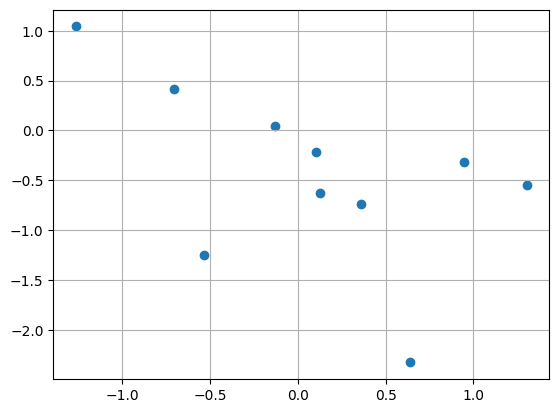

In [22]:
rng = np.random.default_rng(0)
N_PTS = 10

rands_1 = rng.standard_normal(N_PTS)
rands_2 = rng.standard_normal(N_PTS)
plt.scatter(rands_1, rands_2)
plt.grid(True)

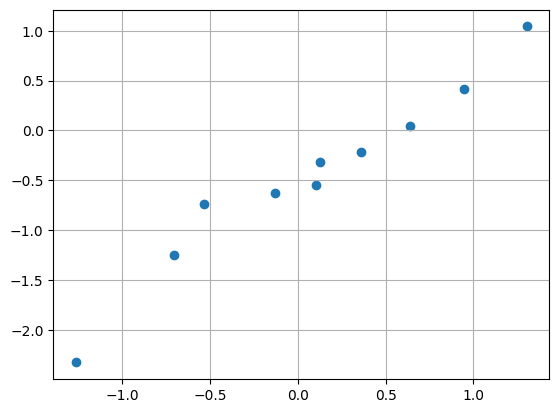

In [24]:
plt.scatter(sorted(rands_1), sorted(rands_2))
plt.grid(True)

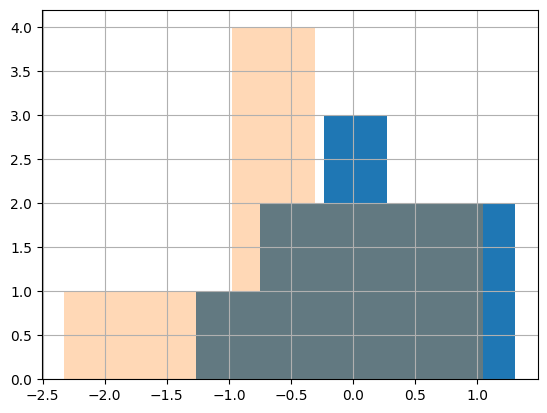

In [25]:
_ = plt.hist(rands_1, bins = 5)
_ = plt.hist(rands_2, bins = 5, alpha = 0.3)
plt.grid(True)

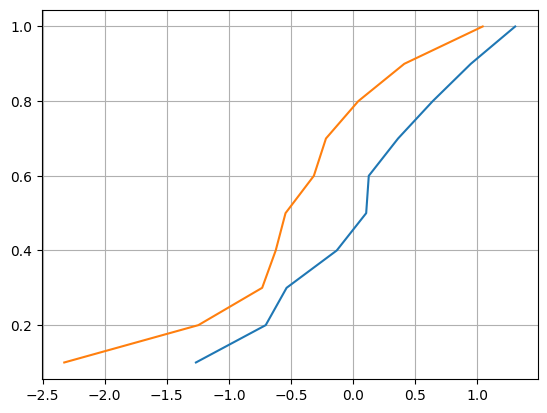

In [26]:
vals_1, probs_1 = cdf(rands_1)
plt.plot(vals_1, probs_1)
plt.grid(True)


vals_2, probs_2 = cdf(rands_2)
plt.plot(vals_2, probs_2)
plt.grid(True)

In [27]:
_x, _y_1, _y_2 = interpolate(vals_1, probs_1, vals_2, probs_2)

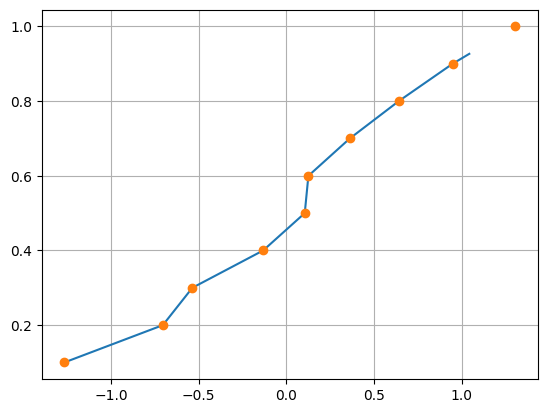

In [28]:
plt.plot(_x, _y_1)
plt.plot(vals_1, probs_1, 'o')
plt.grid(True)

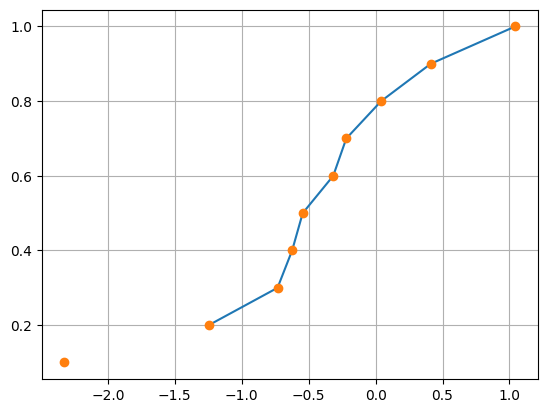

In [29]:
plt.plot(_x, _y_2)
plt.plot(vals_2, probs_2, 'o')
plt.grid(True)

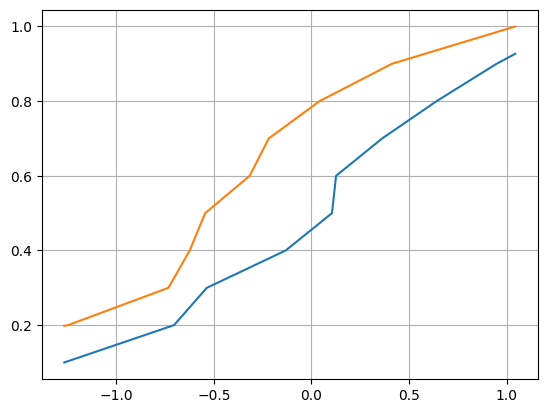

In [30]:
plt.plot(_x, _y_1)
plt.plot(_x, _y_2)
plt.grid(True)

In [31]:
ks_dist(vals_1, probs_1, vals_2, probs_2)


0.33332599801698237

CPU times: total: 6.09 s
Wall time: 5.45 s


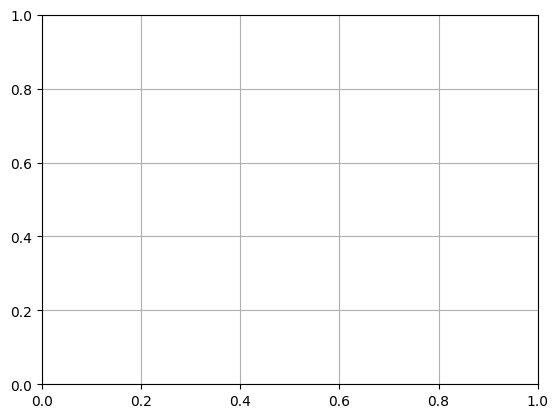

In [32]:
%%time
n_pts = np.logspace(1, 6, 20).astype(int)
dist = [ks_dist(*cdf(rng.standard_normal(n_pt)), *cdf(rng.standard_normal(n_pt))) for n_pt in n_pts]
plt.grid()